# Understanding matrix factorization for recommendation

In [1]:
import numpy as np
import pandas as pd
import math

We are using the **Movielens 100K Dataset**

In [2]:
column_names = ['User_Ids', 'Movie_Ids', 'Rating', 'Tag']
df = pd.read_csv("movielens100k.ratings", sep='\s+', names=column_names).drop('Tag', axis=1)
df_Ratings = df.pivot(index='User_Ids', columns='Movie_Ids', values='Rating')

In [3]:
df_Ratings.head()

Movie_Ids,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_Ids,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_Ratings.shape

(943, 1682)

In [5]:
round(df_Ratings.isnull().sum().sum() / df_Ratings.size * 100, 1)

93.7

So we have a matrix with 943 users (rows) and 1682 items (columns).  
It's a sparse matrix: 93.7% of the values are missing. Our goal is to predict these missing values, using the following formula:
$$
\widehat{r}_{ui} = \mu + b_i + b_u + {q_i}^T \cdot p_u
$$
where $\mu$ is the overall average rating,  
the parameters $b_u$ and $b_i$ indicate the observed deviations of user *u* and item *i*, respectively, from the average  
and the product of *q* and *p* is the user-item interaction.

In [6]:
users = list(df_Ratings.index)
items = list(df_Ratings.columns)
ratings = [tuple(x) for x in df.values]

In [7]:
ratings[0:5]

[(196, 242, 3), (186, 302, 3), (22, 377, 1), (244, 51, 2), (166, 346, 1)]

In [8]:
mu = np.nanmean(df_Ratings.values) # overall average rating  
mu

3.52986

We will use a small fraction of the ratings for our test set:

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.001, random_state=42)

In [10]:
len(test)

100

Defining the parameters for the matrix factorization:

In [11]:
number_of_factors = 7   # latent factors
learning_rate = 0.001
regularization = 0.1
number_of_iterations = 50

Initializing matrix p and q and the bias vectors:

In [16]:
np.random.seed(42)

number_of_users = len(users)
p = np.random.rand(number_of_users, number_of_factors)
b_u = np.random.rand(number_of_users)

number_of_items = len(items)
q = np.random.rand(number_of_items, number_of_factors)
b_i = np.random.rand(number_of_items)

Training the model:

In [17]:
MAE_train_list = []   # Mean Absolute Error
MAE_test_list = []

for it in range(number_of_iterations):
    print("Iteration " + str(it+1) + " of " + str(number_of_iterations))
    
    updated_p = np.array(p)
    updated_b_u = np.array(b_u)
    updated_q = np.array(q)
    updated_b_i = np.array(b_i)
    MAE_train = 0
    MAE_test = 0
    
    for (user, item, rating) in train:
        u = users.index(user)
        i = items.index(item) 
        
        prediction = mu + b_i[i] + b_u[u] + np.dot(p[u,:], q[i,:].transpose())
                                
        error = rating - prediction
        MAE_train += math.fabs(error)
        
        updated_p[u,:] += learning_rate * (error * q[i,:] - regularization * p[u,:])
        updated_b_u[u] += learning_rate * (error - regularization * b_u[u])
        updated_q[i,:] += learning_rate * (error * p[u,:] - regularization * q[i,:])
        updated_b_i[i] += learning_rate * (error - regularization * b_i[i])

    for (user, item, rating) in test:
        u = users.index(user)
        i = items.index(item) 
        
        prediction = mu + b_i[i] + b_u[u] + np.dot(p[u,:], q[i,:].transpose())
                                
        error = rating - prediction
        MAE_test += math.fabs(error)
        
    p = updated_p
    b_u = updated_b_u
    q = updated_q
    b_i = updated_b_i

    MAE_train = MAE_train / len(train)
    MAE_train_list.append(MAE_train)
    MAE_test = MAE_test / len(test)
    MAE_test_list.append(MAE_test)
    
    print("MAE_train:", MAE_train, "MAE_test:", MAE_test)

Iteration 1 of 50
MAE_train: 2.6954453122888693 MAE_test: 2.652338640511272
Iteration 2 of 50
MAE_train: 1.192004431583912 MAE_test: 1.1739552854817805
Iteration 3 of 50
MAE_train: 1.0227089459307057 MAE_test: 0.9896755233335681
Iteration 4 of 50
MAE_train: 0.949936187338763 MAE_test: 0.9414894517763258
Iteration 5 of 50
MAE_train: 0.9117028298089865 MAE_test: 0.9042131952584029
Iteration 6 of 50
MAE_train: 0.8802228290720787 MAE_test: 0.8850283375386528
Iteration 7 of 50
MAE_train: 0.8612326663397278 MAE_test: 0.8688921143533774
Iteration 8 of 50
MAE_train: 0.8433070345763991 MAE_test: 0.8581480697711164
Iteration 9 of 50
MAE_train: 0.8305394268057739 MAE_test: 0.8477071270882593
Iteration 10 of 50
MAE_train: 0.8188958736523382 MAE_test: 0.8381680624363311
Iteration 11 of 50
MAE_train: 0.8095355907102766 MAE_test: 0.8292334678105887
Iteration 12 of 50
MAE_train: 0.8012040342226406 MAE_test: 0.8209178086278951
Iteration 13 of 50
MAE_train: 0.7940603237840129 MAE_test: 0.813149430907743

Plotting the learning curve:

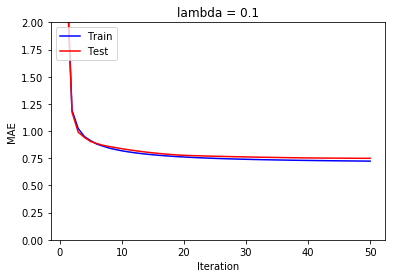

In [18]:
import matplotlib.pyplot as plt

xx1 = np.linspace(1, number_of_iterations, number_of_iterations)
plt.plot(xx1, MAE_train_list, label = 'Train', color='b')
plt.plot(xx1, MAE_test_list, label = 'Test', color='r')
plt.ylim(0, 2)
plt.xlabel("Iteration")
plt.ylabel("MAE")
plt.title("lambda = 0.1")
plt.legend(loc=2)

Saving the learned parameters using numpy:

In [20]:
model_1 = {'p': p, 'b_u': b_u, 'q': q, 'b_i': b_i, 'MAE_train': MAE_train_list, 'MAE_test': MAE_test_list}
np.save('model_1.npy', model_1)

Choosing our active user:

In [21]:
active_user = 1

Looking at the items this user has rated:

In [22]:
items_rated = [item for (user, item, rating) in ratings if user == active_user]

Calculating the predictions for all the items this user hasn't rated:

In [23]:
predictions = {}

u = users.index(active_user)

for i in range(number_of_items):
    item = items[i]
    
    if item not in items_rated:
        prediction = mu + b_i[i] + b_u[u] + np.dot(p[u,:], q[i,:].transpose())
        predictions[item] = prediction

Now we look for the 10 highest reccomendations for user 1:

In [24]:
n = 10

In [25]:
recommendations = {}

for _ in range(n):
    max_prediction = 0
    best_item = None
    
    for item, prediction in predictions.items():
        if prediction > max_prediction and item not in recommendations:
            max_prediction = prediction
            best_item = item
    
    recommendations[best_item] = np.round(max_prediction, 2)

In [26]:
pd.DataFrame(list(recommendations.items()), columns=['Movie', 'Prediction'])

,Movie,Prediction
0,318,4.47
1,483,4.44
2,408,4.35
3,603,4.33
4,1458,4.28
5,1546,4.28
6,313,4.27
7,1638,4.27
8,357,4.26
9,1645,4.26
